In [2]:
from google.colab import files
uploaded = files.upload()

Saving House_Rent_Dataset.csv to House_Rent_Dataset.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

df=pd.read_csv("House_Rent_Dataset.csv")
df.describe()


,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [4]:
print("Original DataFrame Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB
None

Missing Values:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            

In [5]:
df_cleaned = df.dropna()

In [6]:
numeric_columns = ['BHK', 'Rent', 'Size', 'Floor', 'Bathroom']
for col in numeric_columns:
    df_cleaned[col] = pd.to_numeric(
        df_cleaned[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce'
    )

In [7]:
df_cleaned = df_cleaned.dropna(subset=numeric_columns)

In [8]:
if 'Posted On' in df_cleaned.columns:
    df_cleaned['Posted On'] = pd.to_datetime(df_cleaned['Posted On'], errors='coerce')
    df_cleaned['Days Since Posting'] = (pd.Timestamp.now() - df_cleaned['Posted On']).dt.days
    df_cleaned = df_cleaned.dropna(subset=['Days Since Posting'])
    df_cleaned = df_cleaned.drop('Posted On', axis=1)

In [9]:
X = df_cleaned.drop('Rent', axis=1)
y = df_cleaned['Rent']

In [10]:
categorical_columns = ['Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
numeric_columns = ['BHK', 'Size', 'Floor', 'Bathroom']
if 'Days Since Posting' in X.columns:
    numeric_columns.append('Days Since Posting')

print("\nNumeric Columns:", numeric_columns)
print("\nCategorical Columns:", categorical_columns)


Numeric Columns: ['BHK', 'Size', 'Floor', 'Bathroom', 'Days Since Posting']

Categorical Columns: ['Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("\nProcessed Training Data Shape:", X_train_processed.shape)
print("Target Training Data Shape:", y_train.shape)


Processed Training Data Shape: (3796, 1940)
Target Training Data Shape: (3796,)


In [13]:
linear_model = LinearRegression()
linear_model.fit(X_train_processed, y_train)

print("\nModel Coefficients:", linear_model.coef_)
print("Model Intercept:", linear_model.intercept_)
y_pred = linear_model.predict(X_test_processed)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\nTest Mean Absolute Error (MAE): ₹{mae:,.2f}")
print(f"Test Mean Squared Error (MSE): ₹{mse:,.2f}")


Model Coefficients: [ -1209.76419734  21367.56027532   2596.11515959 ... -25009.05135814
  51623.13837512 -26614.08698195]
Model Intercept: 66986.54110962144

Test Mean Absolute Error (MAE): ₹20,717.79
Test Mean Squared Error (MSE): ₹2,474,303,041.69


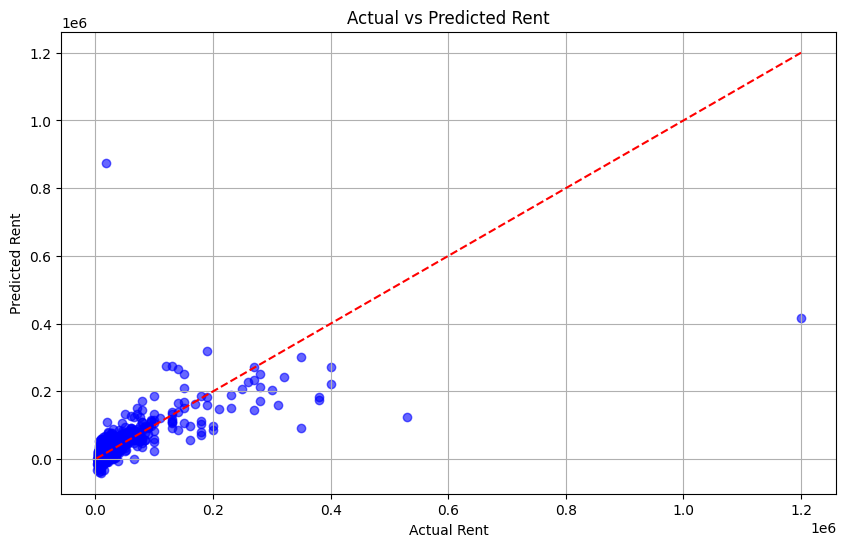

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Actual vs Predicted Rent')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.grid()
plt.show()

In [17]:
sample_input = X_test.iloc[0:1]
sample_processed = preprocessor.transform(sample_input)
predicted_rent = linear_model.predict(sample_processed)
print("\nSample Input Features:")
print(sample_input)
print(f'\nPredicted Rent for Sample Input: ₹{predicted_rent[0]:,.2f}')


Sample Input Features:
      BHK  Size  Floor   Area Type                 Area Locality       City  \
1498    2  1000    4.0  Super Area  Kattigenahalli, Bellary Road  Bangalore   

     Furnishing Status  Tenant Preferred  Bathroom Point of Contact  \
1498    Semi-Furnished  Bachelors/Family         2    Contact Owner   

      Days Since Posting  
1498                 878  

Predicted Rent for Sample Input: ₹22,365.96
